In [1]:
from sklearn import svm, model_selection
from sklearn import metrics
from sklearn.preprocessing import normalize
import json
import itertools
import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = model_selection.GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
DATASET_NAME = '../../json_final/generated/baseline'
test_set = utils.load_from_json('%s_test.json' % DATASET_NAME)
train_set = utils.load_from_json('%s_train_hq.json' % DATASET_NAME)
candidates_limited = utils.load_from_json('%s_candidates_limited.json' % DATASET_NAME)
candidates = utils.load_from_json('%s_candidates.json' % DATASET_NAME)

print('Loaded test dataset with %i classes:' % len(test_set))
for klass, sounds in test_set.items():
    print('\t%s: %i sounds' % (klass, len(sounds)))
print('Loaded train dataset with %i classes:' % len(train_set))
for klass, sounds in train_set.items():
    print('\t%s: %i sounds' % (klass, len(sounds)))
print('Loaded candidates_limited with %i classes:' % len(candidates_limited))
for klass, sounds in candidates_limited.items():
    print('\t%s: %i sounds' % (klass, len(sounds)))
print('Loaded candidates with %i classes:' % len(candidates))
for klass, sounds in candidates.items():
    print('\t%s: %i sounds' % (klass, len(sounds)))
class_names = list(test_set.keys())

Loaded test dataset with 13 classes:
	Coin (dropping): 46 sounds
	Cupboard open or close: 27 sounds
	Door: 40 sounds
	Drawer open or close: 49 sounds
	Keys jangling: 52 sounds
	Microwave oven: 36 sounds
	Packing tape, duct tape: 35 sounds
	Scissors: 52 sounds
	Toilet flush: 66 sounds
	Typing: 64 sounds
	Vacuum cleaner: 44 sounds
	Writing: 71 sounds
	Zipper (clothing): 49 sounds
Loaded train dataset with 13 classes:
	Coin (dropping): 80 sounds
	Cupboard open or close: 64 sounds
	Door: 101 sounds
	Drawer open or close: 67 sounds
	Keys jangling: 70 sounds
	Microwave oven: 62 sounds
	Packing tape, duct tape: 60 sounds
	Scissors: 74 sounds
	Toilet flush: 90 sounds
	Typing: 89 sounds
	Vacuum cleaner: 58 sounds
	Writing: 76 sounds
	Zipper (clothing): 83 sounds
Loaded candidates_limited with 13 classes:
	Coin (dropping): 300 sounds
	Cupboard open or close: 247 sounds
	Door: 300 sounds
	Drawer open or close: 258 sounds
	Keys jangling: 300 sounds
	Microwave oven: 285 sounds
	Packing tape, duct t

In [5]:
for key in candidates_limited.keys():
    for i in range(len(candidates_limited[key])):
        train_set[key].append(candidates_limited[key][i])

In [6]:
for klass, sounds in train_set.items():
    print('\t%s: %i sounds' % (klass, len(sounds)))

	Coin (dropping): 380 sounds
	Cupboard open or close: 311 sounds
	Door: 401 sounds
	Drawer open or close: 325 sounds
	Keys jangling: 370 sounds
	Microwave oven: 347 sounds
	Packing tape, duct tape: 210 sounds
	Scissors: 274 sounds
	Toilet flush: 390 sounds
	Typing: 355 sounds
	Vacuum cleaner: 246 sounds
	Writing: 376 sounds
	Zipper (clothing): 383 sounds


In [7]:
class_names

['Coin (dropping)',
 'Cupboard open or close',
 'Door',
 'Drawer open or close',
 'Keys jangling',
 'Microwave oven',
 'Packing tape, duct tape',
 'Scissors',
 'Toilet flush',
 'Typing',
 'Vacuum cleaner',
 'Writing',
 'Zipper (clothing)']

In [8]:
# CODE TO CLEAN DATASET (remove sounds which do not have analysis information)
test_cleaned = {}
for key, sounds in test_set.items():
    if key not in test_cleaned:
        test_cleaned[key] = []
    for sound in sounds:
        if sound['analysis'] is not None:
            test_cleaned[key].append(sound)
train_cleaned = {}
for key, sounds in train_set.items():
    if key not in train_cleaned:
        train_cleaned[key] = []
    for sound in sounds:
        if sound['analysis'] is not None:
            train_cleaned[key].append(sound)

In [9]:
def build_feature_vector(sound):
    features = []
    #add control if they have it or not
    if (sound['analysis']):
        mfcc_1 = sound['analysis']['lowlevel']['mfcc']['mean'][1]
        mfcc_1_1 = sound['analysis']['lowlevel']['mfcc']['dmean'][1]
        mfcc_2 = sound['analysis']['lowlevel']['mfcc']['mean'][2]
        mfcc_2_1 = sound['analysis']['lowlevel']['mfcc']['dmean'][2]
        mfcc_3 = sound['analysis']['lowlevel']['mfcc']['mean'][3]
        mfcc_3_1 = sound['analysis']['lowlevel']['mfcc']['dmean'][3]
        mfcc_4 = sound['analysis']['lowlevel']['mfcc']['mean'][4]
        mfcc_4_1 = sound['analysis']['lowlevel']['mfcc']['dmean'][4]
        mfcc_5 = sound['analysis']['lowlevel']['mfcc']['mean'][5]
        mfcc_5_1 = sound['analysis']['lowlevel']['mfcc']['dmean'][5]
        mfcc_6 = sound['analysis']['lowlevel']['mfcc']['mean'][6]
        mfcc_6_1 = sound['analysis']['lowlevel']['mfcc']['dmean'][6]
        mfcc_7 = sound['analysis']['lowlevel']['mfcc']['mean'][7]
        mfcc_7_1 = sound['analysis']['lowlevel']['mfcc']['dmean'][7]
        mfcc_8 = sound['analysis']['lowlevel']['mfcc']['mean'][8]
        mfcc_8_1 = sound['analysis']['lowlevel']['mfcc']['dmean'][8]
        mfcc_9 = sound['analysis']['lowlevel']['mfcc']['mean'][9]
        mfcc_9_1 = sound['analysis']['lowlevel']['mfcc']['dmean'][9]
        mfcc_10 = sound['analysis']['lowlevel']['mfcc']['mean'][10]
        mfcc_10_1 = sound['analysis']['lowlevel']['mfcc']['dmean'][10]
        mfcc_11 = sound['analysis']['lowlevel']['mfcc']['mean'][11]
        mfcc_11_1 = sound['analysis']['lowlevel']['mfcc']['dmean'][11]
        mfcc_12 = sound['analysis']['lowlevel']['mfcc']['mean'][12]
        mfcc_12_1 = sound['analysis']['lowlevel']['mfcc']['dmean'][12]

        #feature vector creation
        features = np.concatenate([[], features, np.array([mfcc_1])])
        features = np.concatenate([[], features, np.array([mfcc_1_1])])
        features = np.concatenate([[], features, np.array([mfcc_2])])
        features = np.concatenate([[], features, np.array([mfcc_2_1])])
        features = np.concatenate([[], features, np.array([mfcc_3])])
        features = np.concatenate([[], features, np.array([mfcc_3_1])])
        features = np.concatenate([[], features, np.array([mfcc_4])])
        features = np.concatenate([[], features, np.array([mfcc_4_1])])
        features = np.concatenate([[], features, np.array([mfcc_5])])
        features = np.concatenate([[], features, np.array([mfcc_5_1])])
        features = np.concatenate([[], features, np.array([mfcc_6])])
        features = np.concatenate([[], features, np.array([mfcc_6_1])])
        features = np.concatenate([[], features, np.array([mfcc_7])])
        features = np.concatenate([[], features, np.array([mfcc_7_1])])
        features = np.concatenate([[], features, np.array([mfcc_8])])
        features = np.concatenate([[], features, np.array([mfcc_8_1])])
        features = np.concatenate([[], features, np.array([mfcc_9])])
        features = np.concatenate([[], features, np.array([mfcc_9_1])])
        features = np.concatenate([[], features, np.array([mfcc_10])])
        features = np.concatenate([[], features, np.array([mfcc_10_1])])
        features = np.concatenate([[], features, np.array([mfcc_11])])
        features = np.concatenate([[], features, np.array([mfcc_11_1])])
        features = np.concatenate([[], features, np.array([mfcc_12])])
        features = np.concatenate([[], features, np.array([mfcc_12_1])])
    else:
        print(str(sound['id']) + ": has no analysis")
        #this is wrong but should never happen because we clean the dataset(only for debug)
        features = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    return features

In [10]:
# Prepare data for fitting classifier (as sklearn classifiers require)
y_test = list()
X_test = list()
for class_name, sounds in test_cleaned.items():
    for count, sound in enumerate(sounds):
        # Use index of class name in class_names as numerical value (classifier internally represents
        # class label as number)
        y_test.append(class_names.index(class_name))
        feature_vector = build_feature_vector(sound)
        X_test.append(np.array(feature_vector))
        
# Prepare data for fitting classifier (as sklearn classifiers require)
y_train = list()
X_train = list()
for class_name, sounds in train_cleaned.items():
    for count, sound in enumerate(sounds):
        # Use index of class name in class_names as numerical value (classifier internally represents
        # class label as number)
        y_train.append(class_names.index(class_name))
        feature_vector = build_feature_vector(sound)
        X_train.append(np.array(feature_vector))

In [11]:
#normalize features
#X_normalized = normalize(X)

#with normalization it performs worse!!

In [12]:
#X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3)

In [13]:
#svc_param_selection(X, y, 10)

In [14]:
classifier = svm.SVC(C=10, gamma=0.001)
classifier.fit(X_train, y_train)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [15]:
y_pred = classifier.predict(X_test)

In [16]:
print(metrics.accuracy_score(y_test, y_pred))

0.833333333333


In [17]:
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

In [18]:
class_names_short = ['coi', 'cpb', 'dor', 'drw', 'key', 'mrw', 'pck', 'sci', 'tof', 'typ', 'vcc', 'wrt', 'zip']

Confusion matrix, without normalization
[[32  0  2  0  6  0  1  0  0  1  1  3  0]
 [ 1 22  0  2  0  0  0  0  0  1  0  0  1]
 [ 2  3 16  7  0  2  3  1  1  1  0  2  1]
 [ 0  1  1 43  2  0  0  0  0  0  0  0  0]
 [ 1  0  0  0 51  0  0  0  0  0  0  0  0]
 [ 0  1  0  1  0 32  0  0  1  0  0  0  1]
 [ 0  0  0  2  0  0 30  1  0  0  0  2  0]
 [ 0  0  0  1  1  0  2 47  0  0  0  1  0]
 [ 2  1  3  1  1  0  2  0 53  0  1  0  2]
 [ 0  0  0  0  0  0  2  0  0 57  0  1  1]
 [ 0  0  0  0  0  0  0  0  0  0 43  0  1]
 [ 1  0  2  2  0  0  2  3  1  6  0 53  0]
 [ 1  0  1  3  0  0  0  1  1  0  1  0 41]]


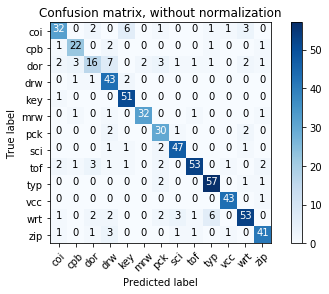

In [19]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names_short,
                      title='Confusion matrix, without normalization')

In [20]:
#report = metrics.classification_report(y_test, y_pred, target_names=class_names_short)
report = metrics.classification_report(y_test, y_pred)

In [21]:
report

'             precision    recall  f1-score   support\n\n          0       0.80      0.70      0.74        46\n          1       0.79      0.81      0.80        27\n          2       0.64      0.41      0.50        39\n          3       0.69      0.91      0.79        47\n          4       0.84      0.98      0.90        52\n          5       0.94      0.89      0.91        36\n          6       0.71      0.86      0.78        35\n          7       0.89      0.90      0.90        52\n          8       0.93      0.80      0.86        66\n          9       0.86      0.93      0.90        61\n         10       0.93      0.98      0.96        44\n         11       0.85      0.76      0.80        70\n         12       0.85      0.84      0.85        49\n\navg / total       0.83      0.83      0.83       624\n'

In [22]:
def classification_report_csv(report):
    report_data = []
    lines = report.split('\n')
    for line in lines[2:-3]:
        row = {}
        row_data = line.split('      ')
        row['class'] = row_data[0]
        row['precision'] = float(row_data[1])
        row['recall'] = float(row_data[2])
        row['f1_score'] = float(row_data[3])
        row['support'] = float(row_data[4])
        report_data.append(row)
    dataframe = pd.DataFrame.from_dict(report_data)
    dataframe.to_csv('classification_report_LQ.csv', index = False)

classification_report_csv(report)